In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
snscolors=sns.color_palette()
snscolors.pop(2)  # take out green
snscolors=np.tile(np.array(snscolors),(10,1))

import pickle
import gzip

In [2]:
imagedir = '../image-output/'
savefigures=False

# Data Definitions and import

In [3]:
import headingchange_models_v6 as hm
import modelfit_plotfns_v2 as pf

In [4]:
# datadir = '/mnt/storage/zfish/'
datadir = '/media/jacob/JD_DATA/zfish/'
resultdir = 'savedresults/'
paramsavedir = resultdir

[treatments] = pickle.load(open(resultdir+'treatmentlist.pkl','rb'))
numtreatments = len(treatments)
[focustreatments,notfocus] = pickle.load(open(resultdir+'focustreatmentlist.pkl','rb'))
[allnumtrials] = pickle.load(open(resultdir+'allnumtrials.pkl','rb'))

# immport combined quantiles
outfile = resultdir+'combinedquantiles.pkl'
[all_speedquantiles10, all_speedquantiles20, all_ndistquantiles, all_bdistquantiles] = pickle.load(open(outfile,'rb'))

treatments_dispnames = np.array([t[:-2] if len(t)>3 else t for t in treatments])

focuscolors=['grey' for _ in range(numtreatments)]
for i in range(1,len(focustreatments)):
    focuscolors[focustreatments[i]] = snscolors[i-1 if i<8 else i]
focuscolors[0] = 'k'

modelnames = ['ik','ikH','ijkHH','ik-Groupsonly']
hcselnames=['heading-fixed30','heading-fixed60','heading-adjusted30','heading-adjusted60','vector-fixed30','vector-fixed60','vector-adjusted30','vector-adjusted60']
hcseldescriptions = ['predict change in heading; all have delay of 30 frames', 'predict change in heading; all have delay of 60 frames',
                    'predict change in heading; WT has delay of 30 frames, others adjusted','predict change in heading; WT has delay of 60 frames, others adjusted',
                    'predict angle change of position vector; all have delay of 30 frames', 'predict angle change of position vector; all have delay of 60 frames',
                    'predict angle change of position vector; WT has delay of 30 frames, others adjusted','predict angle change of position vector; WT has delay of 60 frames, others adjusted'                    ]

refmodel = hm.model_4_FiFjFkHH(sibins=10,sjbins=10,rnumbins=10)   

def getcombinedparams(hcsel,ext,iopostfix,prefix='alltreatmentfit'):
    postfix = '-Lfit' if prefix in treatments else ''
    name = prefix+'-'+('ik' if ext=='ikH' else ext)+'-hcsel'+str(hcsel)+iopostfix[:-4]+postfix
    [_,Afitparams] = pickle.load(open(paramsavedir+name+'.pkl','rb'))
    return Afitparams


In [5]:
outfile = 'fits-hcsel8.pklz'  # contains all 8 differerent variations of the fits

[treatment_params,treatment_allparams,[Lfitext,trialfitext],iopostfixes,
 modelnames,modelsels,groupsels,freezecasenames] = pickle.load(gzip.open(resultdir+outfile,'rb'))
#  modelsels:  # whether or not to fit 'j' and 'H2' functions.   [False,False,True,False] 
#  groupsels:  # whether or not to only fit groups.   [False,False,False,True]
#  holdHconst: # whether or not to fit angular functions (H functions)

numparams = treatment_params.shape[-1]
numfish=6

print('hcsel values and descriptions')
print('\t','value','\t\t','shortname','\t\t','description')
for i in range(8):
    print('\t',i,'\t\t',hcselnames[i],'\t',hcseldescriptions[i])
print('\nResults shown in paper use hcsel=7: ',hcseldescriptions[7])

hcsel values and descriptions
	 value 		 shortname 		 description
	 0 		 heading-fixed30 	 predict change in heading; all have delay of 30 frames
	 1 		 heading-fixed60 	 predict change in heading; all have delay of 60 frames
	 2 		 heading-adjusted30 	 predict change in heading; WT has delay of 30 frames, others adjusted
	 3 		 heading-adjusted60 	 predict change in heading; WT has delay of 60 frames, others adjusted
	 4 		 vector-fixed30 	 predict angle change of position vector; all have delay of 30 frames
	 5 		 vector-fixed60 	 predict angle change of position vector; all have delay of 60 frames
	 6 		 vector-adjusted30 	 predict angle change of position vector; WT has delay of 30 frames, others adjusted
	 7 		 vector-adjusted60 	 predict angle change of position vector; WT has delay of 60 frames, others adjusted

Results shown in paper use hcsel=7:  predict angle change of position vector; WT has delay of 60 frames, others adjusted


# Plot fit results

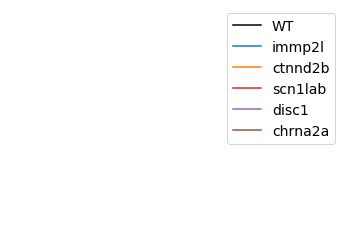

In [6]:
[plt.plot([1],[1],c=focuscolors[i],label=treatments_dispnames[i]) for i in focustreatments]
plt.legend(fontsize=14)
plt.axis('off')
plt.savefig(imagedir+'linelegend.pdf') if savefigures else None

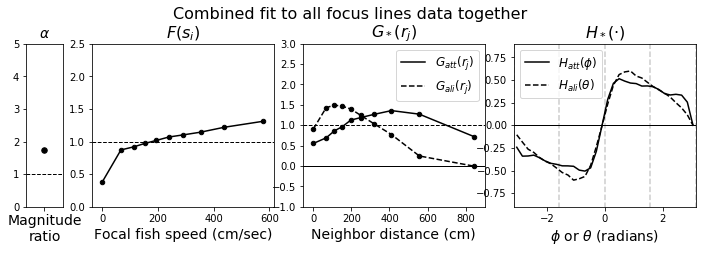

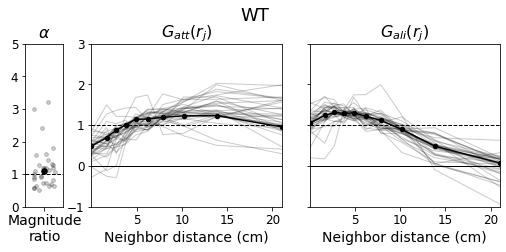

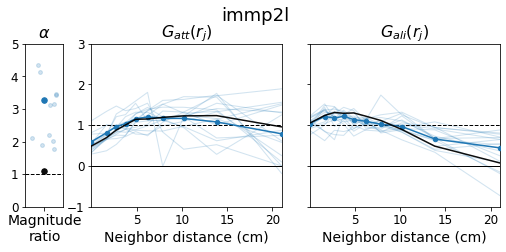

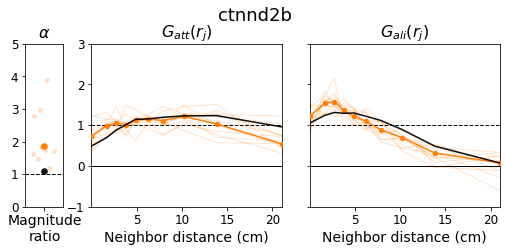

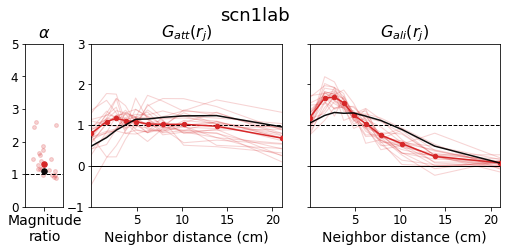

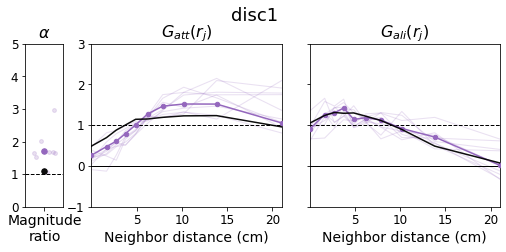

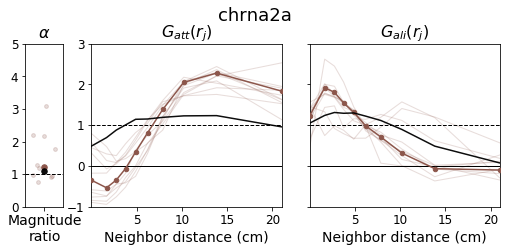

In [7]:
# create figure if saving

if savefigures:
    import matplotlib.backends.backend_pdf
    pdf = matplotlib.backends.backend_pdf.PdfPages(imagedir+'Modelfits.pdf')

ionum=0
modelnum=0
hcsel=7
fnum=0   
combinedio = '-io10-A10-far10.pkl' if ionum==0 else '-io50-A10-far05.pkl'
combinedparams = getcombinedparams(hcsel,modelnames[modelnum],combinedio,prefix="focustreatmentfit")

ax = pf.plotfit_simple(refmodel,combinedparams)       
plt.suptitle('Combined fit to all focus lines data together',fontsize=16,y=1.05)
pdf.savefig() if savefigures else None
plt.show()

plotfn = pf.plotfit_noangle
plotfn = pf.plotfit_justdist

for tnum in focustreatments:
    
    ax = pf.plotTfit(plotfn,refmodel,treatment_allparams[ionum][modelnum][fnum][hcsel][tnum], allnumtrials[tnum],color=focuscolors[tnum])
    if tnum>0:
        plotfn(refmodel,treatment_allparams[ionum][modelnum][fnum][hcsel][0],ax=ax,color='k',alphaval=0.95)

    plt.suptitle(treatments_dispnames[tnum],fontsize=18,y=1.05)
    
    ax[0].set_ylim([0,5])  
    [a.set_ylim([-1,3]) for a in ax[1:]]
    pdf.savefig() if savefigures else None
    plt.show()
    
pdf.close() if savefigures else None    

# Loss and fraction predicted correct

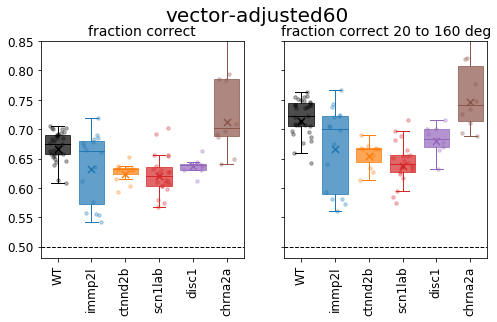

In [8]:
modelnum=0

[treatment_errorsave,trial_errorsave] = pickle.load(open(resultdir+'focus_errorsave-hcsel8-abbrv-model'+str(modelnum)+'.pkl','rb'))
hcsel=7


errornames = ['loss', 'loss_zeronorm', 'fraction correct', 'fraction correct 20 to 160 deg']

f,ax = plt.subplots(1,2,sharex=True,sharey=True)
f.set_size_inches(8,4)

for esel in [2,3]:
    a=ax[esel-2]

    count=0
    for tnum in focustreatments:
        spacing=0.2
        y = np.array(trial_errorsave[tnum][hcsel])[:,esel]
        x = 0.6*spacing*(np.random.rand(len(y))-0.5) + count*spacing
        a.scatter(x, y, s=12,color=focuscolors[tnum], alpha=0.3,zorder=10)
        bp = a.boxplot(y,positions=[count*spacing],
                       patch_artist=True,showfliers=False)
        for patch in bp['boxes']:
            patch.set(color=focuscolors[tnum],alpha=0.7)  
        for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
            plt.setp(bp[element], color=focuscolors[tnum])        
        a.scatter([count*spacing],treatment_errorsave[tnum,hcsel,esel],color=focuscolors[tnum],s=50,zorder=100,marker='x')



        count+=1

    a.set_title(errornames[esel],fontsize=14)

    a.set_xticks(np.arange(len(focustreatments))*spacing)
    a.set_xticklabels(treatments_dispnames[focustreatments],fontsize=12,rotation='vertical')
    a.set_xlim([0-spacing/2,len(focustreatments)*spacing-spacing/2])
    a.axhline(0.5,c='k',linestyle='--',linewidth=1)
a.set_ylim([0.48,0.85])
ax[0].tick_params(labelsize=12)
plt.suptitle(hcselnames[hcsel],fontsize=20,y=1)
plt.savefig(imagedir+'modelfits-loss-model'+str(modelnum)+'.pdf')
plt.show()